### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

### Loading the data

In [4]:
official_names = ['Pinene', 'Benzyl_benzoate']

In [48]:
protons = [16, 12]

In [6]:
# ppm = #np.array with shape (number_of_points on frequency axis for mixture,)
# mix = #np.array with shape (number_of_points on frequency axis,)
# ppm_comp = #np.array with shape (number_of_points on frequency axis for components, )
# components = #np.array with shape (number_of_points on frequency axis for components, number of components)
# real_visible_proportions = #np.array with shape (number of components,)

In [7]:
data = np.loadtxt(os.getcwd()+'/mini_perfumy_duze_pole_CDCl3.csv', skiprows=1, usecols=range(5),
                      delimiter='\t',dtype=float)
ppm = data[:,0]
mix = data[:,4]
ppm_components = data[:,0]
components = data[:,1:3]

In [8]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [9]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [10]:
mix = Spectrum(confs=list(zip(ppm,mix)))

### Preprocessing

In [11]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [12]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [13]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [14]:
spectra_and_mixture = spectra + [mix]

In [15]:
spectra_and_mixture = shift(spectra_and_mixture)

In [16]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [17]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [18]:
cma = common_mass_axis(spectra_and_mixture)

In [19]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [20]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [21]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [22]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [23]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [24]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [25]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


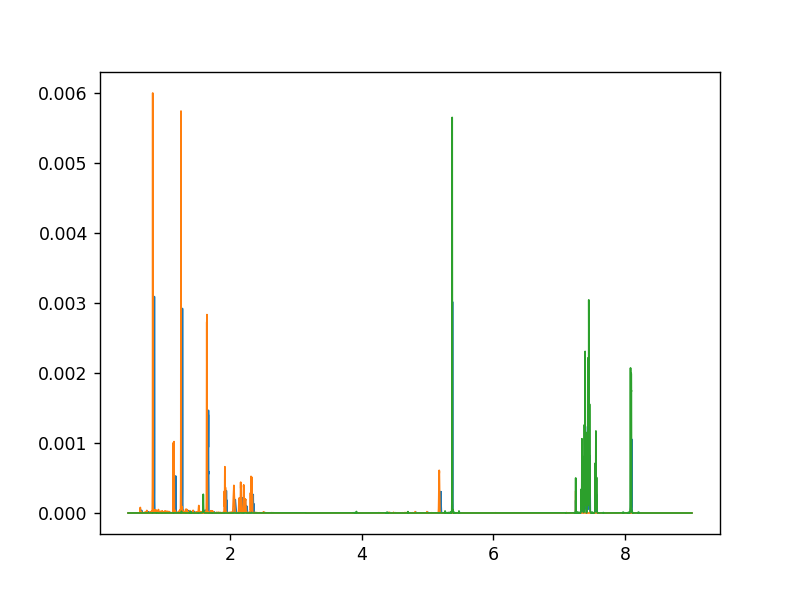

In [26]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 

### Estimation

In [43]:
estimation = estimate_proportions(mix, spectra, 
                                   MTD=0.34, MTD_th=0.34, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|█████████████| 2/2 [00:00<00:00, 117.02it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.457009, 9.01304, 0), (0.457009, 9.01304, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(0.11700899999999997, 9.35304)]


Splitting the experimental spectrum into chunks: 70340it [00:00, 3478972.95it/s]


Ion currents in chunks: [0.9999999999999998]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 281359 rows, 70343 columns and 700269 nonzeros
Model fingerprint: 0xb41cd57b
Coefficient statistics:
  Matrix range     [6e-12, 1e+00]
  Objective range  [7e-12, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [1e-04, 3e-01]
Presolve removed 78091 rows and 0 columns
Presolve time: 27.34s
Presolved: 70343 rows, 281358 columns, 700268 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.486e+05
 Factor NZ  : 1.442e+06 (roughly 150 MB of memory)
 Factor Ops : 3.415e+07 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter  

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:50<00:00, 50.78s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.997522383008
Noise proportion in experimental spectrum: 0.002477616992000003
Total explanation: 1.0
Noise proportion in combination of theoretical spectra: 0.006484042563


In [44]:
estimation['proportion_of_noise_in_theoretical']

0.006484042562999998

In [45]:
p = estimation['proportions']
p

[0.4621745689769999, 0.5353478140309998]

In [46]:
prop = [p/prot for p, prot in zip(p, protons)]
prop = [p/sum(prop) for p in prop]
prop

[0.3930150588806537, 0.6069849411193463]

In [47]:
real_proportions = [0.3865, 0.6135]
real_proportions 

[0.3865, 0.6135]

In [50]:
real_visible_proportions = [prop*prot for prop, prot in zip(real_proportions, protons)]
real_visible_proportions = [p/sum(real_visible_proportions) for p in real_visible_proportions]
real_visible_proportions 

[0.4565185294551898, 0.5434814705448103]

### Visualisation of our estimation

In [33]:
p = np.array(p).reshape(len(p),1)

In [34]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [35]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [36]:
X = np.concatenate(components_ints, axis=1)

In [37]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


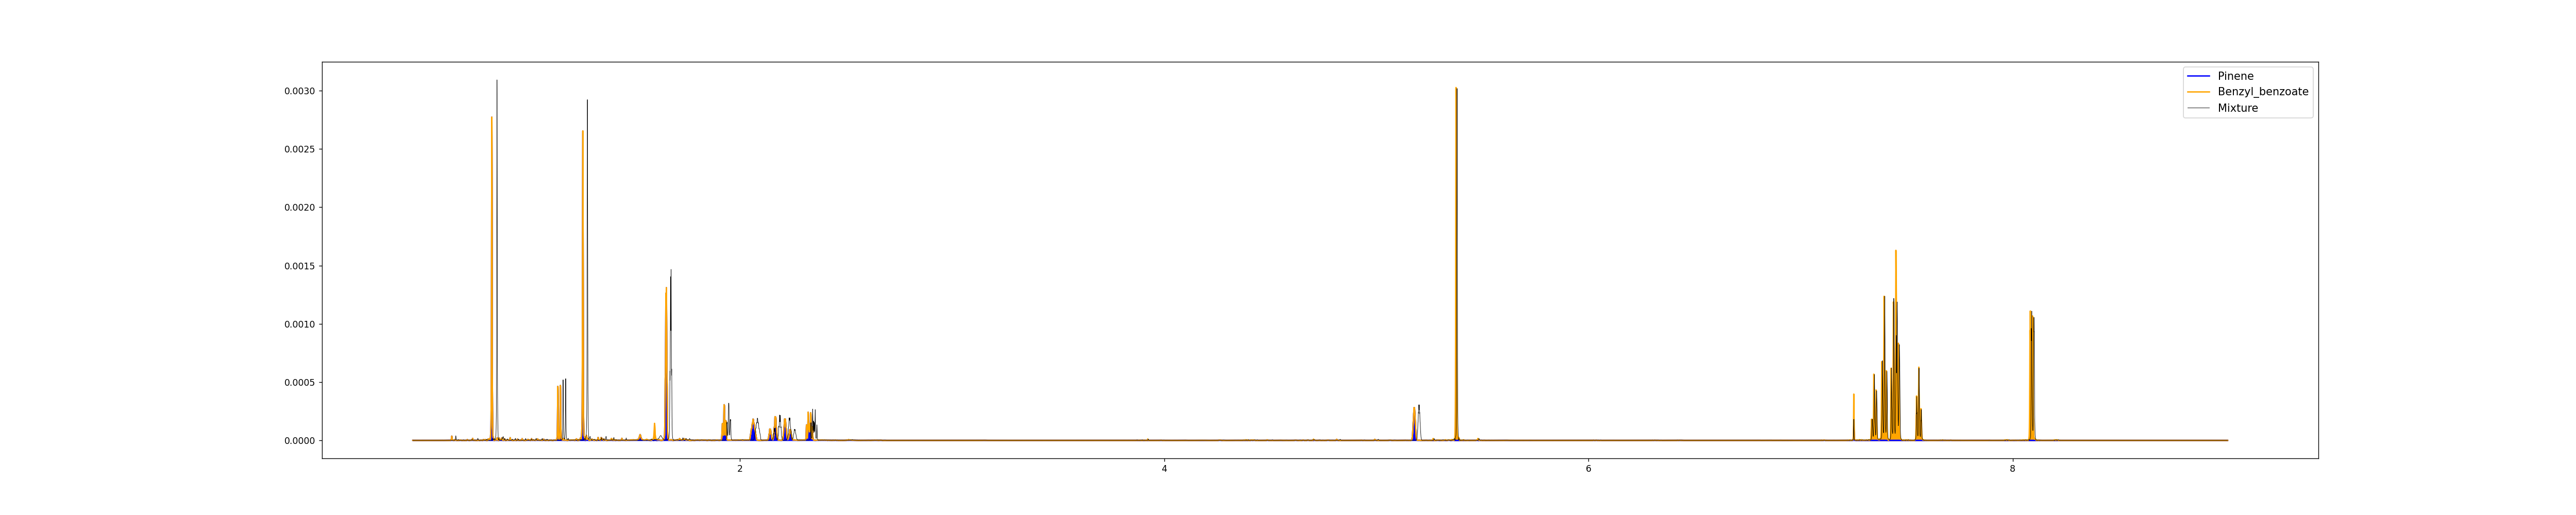

In [43]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(40, 8, forward=True)
# ax.set_xlim(57,59.5)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12})
